In [1]:
from torch_DE.benchmark import get_config_dict
from torch_DE.equations import get_NavierStokes,get_derivatives
from torch_DE.geometry.shapes import *
from torch_DE.continuous.Engines import FD_engine
from torch_DE.continuous import DE_Getter
from torch_DE.continuous.Networks import MLP,Wang_Net,Fourier_Net
from torch.optim.lr_scheduler import StepLR
from torch_DE.utils import R3_sampler,Data_handler,Loss_handler,GradNorm,sample_from_tensor
from torch_DE.utils.sampling import add_random_time,add_time_col,add_time_point
#Post Process
from torch_DE.post import Plotter,Validation_module
import pandas as pd
#Other
from numpy.random import seed as np_seed
from timeit import default_timer as timer
import os

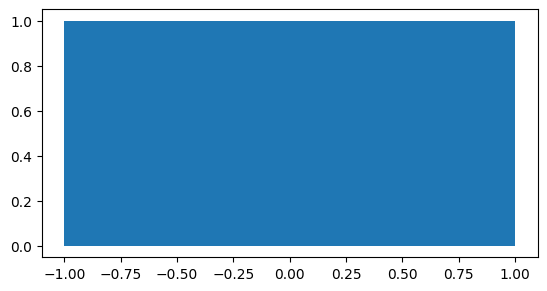

In [17]:
(xmin,xmax),(tmin,tmax) = (-1,1),(0,1)
domain = Domain2D(base = Rectangle(((xmin,tmin),(xmax,tmax))),is_rectangle=True  )

boundary_points = domain.generate_boundary_points(200)
sampled_points = domain.generate_points(100_000)
domain.plot()

In [18]:
def u_IC(x):
    return x[:,0]**2*torch.cos(torch.pi*x[:,0])

def AllenCahn(u_t,u_xx,u,**kwargs):
    return u_t - 0.0001*u_xx + 5*u**3 -5*u
input_vars,output_vars = (['x','t'],['u'])
derivatives = get_derivatives(input_vars,output_vars,AllenCahn)

In [19]:

data = Data_handler()
data['IC'] = boundary_points['bot wall']
data['col'] = sample_from_tensor(2000,t = sampled_points,causal=True)
data['x_p1'] = boundary_points['left wall']
data['x_p2'] = boundary_points['right wall']

losses = Loss_handler(data.group_names())
losses.add_initial_condition('IC',{'u':u_IC})
losses.add_periodic('x_p1','x_p2','u')
losses.add_periodic('x_p1','x_p2','u_x')
losses.add_residual('col',{'AllenCahn':AllenCahn})

sampled_points = sampled_points.cuda()
data.set_to_device('cuda')

In [ ]:

torch.manual_seed(1234)
last_weights = []
torch.manual_seed(1234)
net = Fourier_Net(2,1,50,4,RWF=True)
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
LR_sch = StepLR(optimizer,2000,0.9)

PINN = DE_Getter(net,input_vars,output_vars,derivatives)
net = net.cuda()
for i in range(0,100_001):
    
    output = PINN.calculate(data)
    loss = losses.calculate(data,output,causal=True)
    
    l = loss.individual_loss()
    ls = [100*l['Initial Condition'],100*l['Periodic'],l['Residual']]
    ls = sum(ls)
    ls.backward()
    
    data['col'] = sample_from_tensor(2000,t = sampled_points,causal=True)
    optimizer.step()
    optimizer.zero_grad()
    LR_sch.step()
    
    if i%10 == 0:
        with torch.no_grad():
            loss.print_losses(i)
            print(f'Last Weight {loss.causal_weighting[-1]:.3E}')
            

    

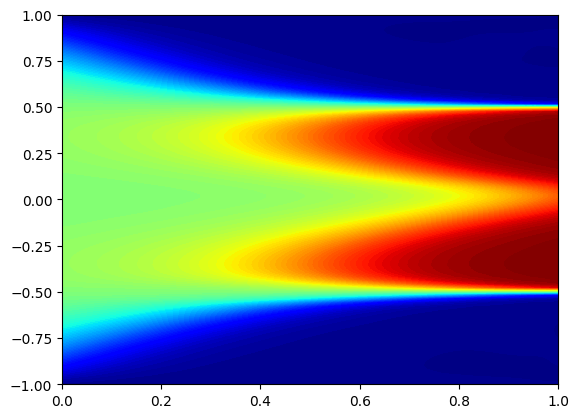

In [21]:
X,T = torch.meshgrid([torch.linspace(-1,1,100),torch.linspace(0,1,100)],indexing='ij')
xt = torch.stack([X.flatten(),T.flatten()],dim = -1)

with torch.no_grad():
    out = net.cpu()(xt)

plt.tricontourf(xt[:,1],xt[:,0],out[:,0],levels =100,cmap='jet')